<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Dataset 2: Change Detection Behavior + Optical Physiology </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Tuesday, August 21, 2018</h3> 

<img src="../resources/change_detection_schematic.png" height="400" width="400">  


This notebook will introduce you to the Visual Behavior pilot dataset. This pre-release dataset uses 2-photon calcium imaging to measure neural activity in mice performing an image change detection task, and was collected during piloting for the new Visual Behavior Brain Observatory. Production data collection for the Observatory will begin September 2018 and data will be publicly released in 2019. The insights obtained here at SWDB may help shape the collection of the production dataset. 

In this notebook, we will describe the dimensions of the dataset, the core components of each experimental session, and the tools for accessing and analyzing the data. 

By the end of the notebook, you will compute stimulus selectivity across a population of neurons from a mouse performing the change detection task, and compare the mean selectivity value with other experiments in the dataset coming from different cell populations.

** Outline:**
1. Explore the dimensions of the dataset using the manifest file 
2. Explore the contents of a single experiment session using the VisualBehaviorOphysDataset class
3. Use the ResponseAnalysis class to explore neural activity for specific stimulus or behavioral conditions 
4. Identify all the cells in your experiment with a significant visual response
5. Compute a metric called lifetime sparseness for the visually responsive neurons in your experiment 
6. Compare your metric value with other experiments in the dataset 
7. Additional exercises & project ideas 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p>Let's get started

</div>

In [72]:
# you will need these libraries for computation & data manipulation
import os
import numpy as np
import pandas as pd

# matplotlib is a standard python visualization package
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn is another library for statistical data visualization
# seaborn style & context settings make plots pretty & legible
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
# sns.set_style('white')
sns.set_palette('deep');

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>The dimensions of the dataset are described in the manifest file. You can inspect the manifest to identify experiments of interest and their metadata. 

<p>The manifest file is located in the cache directory, along with the data itself. 

<p>Make sure your 'cache_dir' is set properly, and complete the following task to load and inspect the 'manifest_file'. </div>



In [73]:
# macOS/OS X
# cache_dir = r'/Volumes/Brain2018/data/dynamic-brain-workshop/brain_observatory_cache/'

# Windows 
cache_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\visual_behavior_pilot_analysis'

# Linux 
# cache_dir = r'/media/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache'

# AWS
# cache_dir = '/data/dynamic-brain-workshop/brain_observatory_cache/'

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.1:**  Get information about what's in the dataset 

<p>Read in visual_behavior_data_manifest.csv using pandas and explore the columns to see the available visual areas, cre lines, and session types. 

</div>

In [74]:
manifest_file = 'visual_behavior_data_manifest.csv'

In [75]:
manifest = pd.read_csv(os.path.join(cache_dir,manifest_file))

In [76]:
manifest.head()

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,specimen_id,experiment_date
0,644942849,644919226,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_A,329071,596175193,10/24/2017 10:32
1,645035903,644919226,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_B,329071,596175193,10/25/2017 10:34
2,645086795,644919226,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_C,329071,596175193,10/26/2017 10:27
3,645362806,644919226,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_D,329071,596175193,10/30/2017 11:41
4,646922970,646555436,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_A,330982,596393048,11/7/2017 14:19


In [77]:
print 'targeted structures:', manifest.targeted_structure.unique()
print 'cre_lines:', manifest.cre_line.unique()
print 'stimulus_types:', manifest.session_type.unique()

targeted structures: ['VISp' 'VISal']
cre_lines: ['Vip-IRES-Cre' 'Slc17a7-IRES2-Cre']
stimulus_types: ['behavior_session_A' 'behavior_session_B' 'behavior_session_C'
 'behavior_session_D']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.2:**  Everyone gets an experiment! 

<p>Get your experiment ID and assign it to a variable called experiment_id

<p>What is the targeted_structure, cre_line and session_type for your experiment_id? 

</div>

In [78]:
experiment_id = 719321260

In [79]:
manifest[manifest.experiment_id==experiment_id]

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,specimen_id,experiment_date
56,719321260,719538773,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,385255,685152008,7/12/2018 10:27


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.3:**  What is in an experiment container? 

<p>The experiment container describes a set of experiment sessions performed at the same location (targeted area and imaging depth) in the same mouse that targets the same set of cells. All the sessions in an experiment container have a common experiment_container_id

<p>Get a the experiment_container_id for your experiment_id and find out what other sessions were recorded at that same location

<p>Do all experiment containers have the same number of sessions associated with them? 

</div>

In [80]:
experiment_container_id = manifest[manifest.experiment_id==experiment_id].experiment_container_id.values[0]
print experiment_container_id

719538773


In [81]:
manifest[manifest.experiment_container_id==experiment_container_id]

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,specimen_id,experiment_date
56,719321260,719538773,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,385255,685152008,7/12/2018 10:27
57,719996589,719538773,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_B,385255,685152008,7/13/2018 10:13
58,723748162,719538773,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_C,385255,685152008,7/23/2018 11:18
59,723037901,719538773,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_D,385255,685152008,7/20/2018 13:47


In [82]:
for experiment_container_id in manifest.experiment_container_id.unique(): 
    container = manifest[manifest.experiment_container_id==experiment_container_id]
    print 'number of sessions associated with experiment_container_id',str(experiment_container_id),' = ',str(len(container))

number of sessions associated with experiment_container_id 644919226  =  4
number of sessions associated with experiment_container_id 646555436  =  4
number of sessions associated with experiment_container_id 648562391  =  3
number of sessions associated with experiment_container_id 652784528  =  3
number of sessions associated with experiment_container_id 639001089  =  4
number of sessions associated with experiment_container_id 661409179  =  4
number of sessions associated with experiment_container_id 670266085  =  4
number of sessions associated with experiment_container_id 682951696  =  2
number of sessions associated with experiment_container_id 695444116  =  4
number of sessions associated with experiment_container_id 700821114  =  4
number of sessions associated with experiment_container_id 692315205  =  4
number of sessions associated with experiment_container_id 712038821  =  4
number of sessions associated with experiment_container_id 715027436  =  4
number of sessions associ

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The VisualBehaviorOphysDataset object</h2>
<p>The dataset object contains all the data and metadata for a single experiment session, including dF/F traces, behavior data, and timing information. 

<p>Provide your experiment_id and your cache directory to load the data for an experiment. 

<p>Use help to see what functions are contained in the VisualBehaviorOphysDataset class. 

</div>

In [83]:
# import visual behavior dataset class from the visual_behavior package
from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset

In [84]:
dataset= VisualBehaviorOphysDataset(experiment_id, cache_dir=cache_dir)

In [85]:
help(VisualBehaviorOphysDataset)

Help on class VisualBehaviorOphysDataset in module visual_behavior.ophys.dataset.visual_behavior_ophys_dataset:

class VisualBehaviorOphysDataset(__builtin__.object)
 |  Methods defined here:
 |  
 |  __init__(self, experiment_id, cache_dir=None)
 |      Initialize visual behavior ophys experiment dataset.
 |          Loads experiment data from cache_dir, including dF/F traces, roi masks, stimulus metadata, running speed, licks, rewards, and metadata.
 |      
 |      Parameters
 |      ----------
 |      experiment_id : ophys experiment ID
 |      cache_dir : directory where data files are located for loading
 |  
 |  get_analysis_dir(self)
 |  
 |  get_cache_dir(self)
 |  
 |  get_cell_index_for_cell_specimen_id(self, cell_specimen_id)
 |  
 |  get_cell_indices(self)
 |  
 |  get_cell_specimen_id_for_cell_index(self, cell_index)
 |  
 |  get_cell_specimen_ids(self)
 |  
 |  get_dff_traces(self)
 |  
 |  get_licks(self)
 |  
 |  get_max_projection(self)
 |  
 |  get_metadata(self)
 | 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.1:**  What is an experiment dataset? 

<p>Use tab completion to see what is in the dataset object for an experiment session

<p>Whats in the metadata? Make sure it matches what you found in the manifest for this experiment_id.

</div>


In [86]:
dataset.metadata

,ophys_experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,experiment_date,specimen_id,ophys_frame_rate,stimulus_frame_rate
719321260,719321260,None,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,385255,2018-07-12,685152008,31.0,60.0


In [87]:
# make sure this is the experiment you selected
print 'targeted_structure:', dataset.metadata.targeted_structure.values[0]
print 'cre line:', dataset.metadata.cre_line.values[0]
print 'imaging_depth:', dataset.metadata.imaging_depth.values[0]

targeted_structure: VISal
cre line: Slc17a7-IRES2-Cre
imaging_depth: 175


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 2.4:** Get the maximum intensity projection image for your dataset and display it. 
</div>

(-0.5, 446.5, 511.5, -0.5)

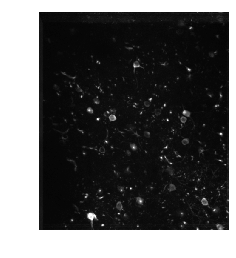

In [88]:
plt.imshow(dataset.max_projection,cmap='gray',)
plt.axis('off')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 2.5:** Plot the dF/F trace for a cell by indexing into the dff_traces array

<p>Get the timestamps for ophys acquisition frames and plot the dF/F trace in seconds

<p>What does the trace look like for other cells?

</div>

In [89]:
# pick a cell 
cell_index = 8

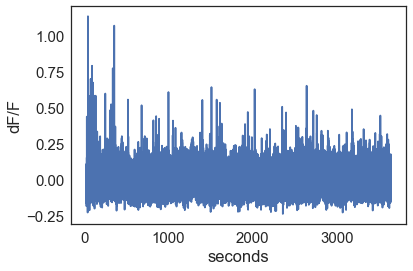

In [90]:
plt.plot(dataset.timestamps_ophys,dataset.dff_traces[cell_index])
plt.xlabel('seconds')
plt.ylabel('dF/F')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 2.6:** Get the cell_specimen_id for your cell index
</div>

In [91]:
cell_specimen_id = dataset.get_cell_specimen_id_for_cell_index(cell_index)
print cell_specimen_id

719333939


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 2.7:** Plot the roi mask for that cell using the cell_specimen_id to index into the roi_masks dictionary. 
</div>

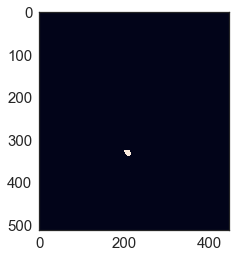

In [92]:
# use cell_specimen_id for roi_dict
plt.imshow(dataset.roi_masks[str(cell_specimen_id)])
plt.grid('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior timeseries and events - running, licks, rewards, and visual stimuli </h2>
<p>As the mouse performs the behavioral task, it is free to run on a disk. The task is a go/no-go style task with licking as the behavioral response. When a mouse correctly licks the water spout, a reward is delivered. 

<p>Running, licks and rewards are measured at the stimulus frame display rate and share timestamps with the stimulus. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.1:** Plot running speed

<p>Note that dataset.running_speed is a dataframe. Values for running speed need to be extracted from this dataframe. 

<p>Plot the x-axis in seconds, using 'timestamps_stimulus'
<p>Running speed is measured in cm/s. Label the axes appropriately. 
</div>

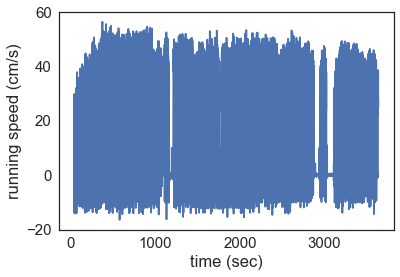

In [93]:
plt.plot(dataset.timestamps_stimulus,dataset.running_speed.running_speed.values)
plt.xlabel('time (sec)')
plt.ylabel('running speed (cm/s)')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.2:** Plot licking and reward times
    
<p>Re-create the plot above. Set xlims to focus on a 1 minute portion of the behavior session, from x=600 to x=660. 

<p>Plot licking and rewards as points (not a line), at y = -10. Use different colors or marker types for licks and rewards.

<p>Hint: You will need to create an array of len(dataset.licks.time.values) filled with -10 to plot.

<p>Create a legend. Bonus: place the legend outside of the main figure.

<p>What is the relationship between running, licking and rewards? 
</div>

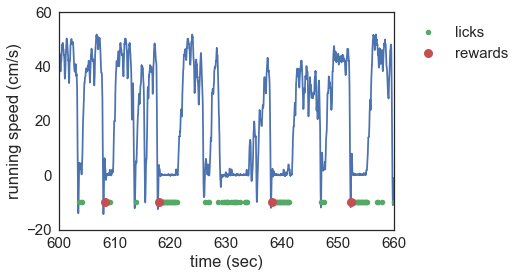

In [94]:
plt.plot(dataset.timestamps_stimulus,dataset.running_speed.running_speed.values)
#plot licks
lick_y_vals = np.empty(len(dataset.licks.time.values))
lick_y_vals[:] = -10
plt.plot(dataset.licks.time.values,lick_y_vals,'.',label='licks')
#plot rewards
reward_y_vals = np.empty(len(dataset.rewards.time.values))
reward_y_vals[:] = -10
plt.plot(dataset.rewards.time.values,reward_y_vals,'o',label='rewards')

plt.xlim(600,660)
plt.xlabel('time (sec)')
plt.ylabel('running speed (cm/s)')
plt.legend(loc=9, bbox_to_anchor=(1.2,1))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.3:** Plot visual stimulus times

<p>Get 'stimulus_table' from the dataset to identify the times of stimulus presentations. How many stimulus flashes were there? 

<p>Recreate the plot above, but zoom in on a 20 second window. 

<p>Plot stimulus presentations using plt.axvspan() with alpha=0.3 & facecolor='gray'

<p>Hint: loop through each row of stimulus table and use 'start_time' and 'end_time'

</div>

In [95]:
dataset.stimulus_table.head()

,flash_number,start_frame,end_frame,start_time,end_time,duration,image_category,image_name,orientation,contrast
0,0,1,16,34.88175,35.13180,35.130590,im061,im061,None,None
45,1,46,61,35.63224,35.88243,35.131233,im061,im061,None,None
90,2,91,106,36.38278,36.63304,35.131023,im061,im061,None,None
135,3,136,151,37.13337,37.38367,35.131331,im061,im061,None,None
180,4,181,196,37.88405,38.13426,35.131247,im061,im061,None,None


In [96]:
print 'number of stimulus presentations =',len(dataset.stimulus_table)

number of stimulus presentations = 4581


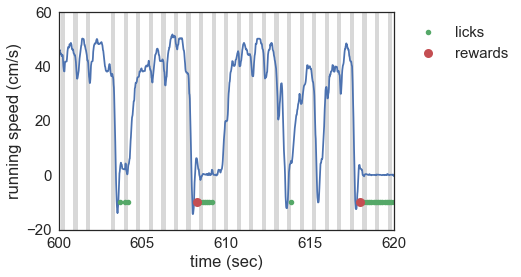

In [97]:
plt.plot(dataset.timestamps_stimulus,dataset.running_speed.running_speed.values)
#plot licks
lick_y_vals = np.empty(len(dataset.licks.time.values))
lick_y_vals[:] = -10
plt.plot(dataset.licks.time.values,lick_y_vals,'.',label='licks')
#plot rewards
reward_y_vals = np.empty(len(dataset.rewards.time.values))
reward_y_vals[:] = -10
plt.plot(dataset.rewards.time.values,reward_y_vals,'o',label='rewards')

for flash_number in dataset.stimulus_table.flash_number.values:
    row_data = dataset.stimulus_table[dataset.stimulus_table.flash_number==flash_number]
    plt.axvspan(xmin=row_data.start_time.values[0],xmax=row_data.end_time.values[0],facecolor='gray',alpha=0.3)

plt.xlim(600,620)
plt.xlabel('time (sec)')
plt.ylabel('running speed (cm/s)')
plt.legend(loc=9, bbox_to_anchor=(1.2,1))


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.3:** Get visual stimulus data

<p>Get 'stimulus_metadata' and 'stimulus_template' from the dataset object. How do they relate to each other?

<p>Plot an image using plt.imshow. Show the image_name in the title.

<p>Hint: 'image_index' of 'stimulus_metadata' corresponds to the index in 'stimulus_template'

</div>

In [98]:
stimulus_metadata = dataset.stimulus_metadata
stimulus_metadata

,image_category,image_index,image_name
0,im065,0,im065
1,im077,1,im077
2,im066,2,im066
3,im061,3,im061
4,im063,4,im063
5,im062,5,im062
6,im085,6,im085
7,im069,7,im069


In [99]:
stimulus_template = dataset.stimulus_template
stimulus_template.shape

(8L, 918L, 1174L)

In [100]:
stimulus_metadata

,image_category,image_index,image_name
0,im065,0,im065
1,im077,1,im077
2,im066,2,im066
3,im061,3,im061
4,im063,4,im063
5,im062,5,im062
6,im085,6,im085
7,im069,7,im069


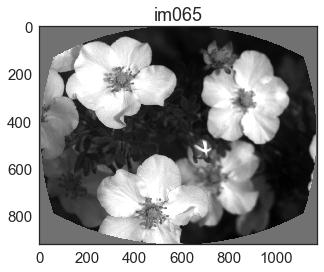

In [101]:
image_name = stimulus_metadata.image_name.values[0]
image_index = stimulus_metadata[stimulus_metadata.image_name==image_name].image_index.values[0]
image_data = stimulus_template[image_index]
plt.imshow(image_data,cmap='gray')
plt.title(image_name)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Change Detection task - behavioral trials</h2>
<p>The change detection task consists of a series of image presentations. Each image flash is 250ms followed by 500ms of gray screen. The task for the mouse is to lick in a 750ms response window following a change in image identity. 
<p>On each trial, a change time is scheduled. On go trials, a change in image identity occurs. On catch trials, no image change occurs (aka 'sham change'), and we measure false alarm rates in the same 750ms response window. The dataset object has a record of every trial, both 'go' and 'catch', including information about what images were shown before and after the change time, the times of the mouse's licks, reward delivery, and other metadata for each trial.  


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 4.1:** Get the trial records from the dataset object. 
<p>What images were shown in this behavior session? 
<p>How many trials were there? 
<p>How many of those trials had stimulus changes, aka 'go' trials?
<p>Hint: Use the value of the 'trial_type' column to filter the dataframe
</div>

In [102]:
trials = dataset.trials
trials.head()

,trial,original_trial_index,auto_rewarded,change_contrast,change_frame,change_image_category,change_image_name,change_ori,change_time,cumulative_reward_number,...,number_of_rewards,rig_id,trial_type,lick_frames,reward_licks,reward_lick_count,reward_lick_latency,reward_rate,response,color
0,0,32,False,1.0,6704.0,im077,im077,90.0,146.75620,5,...,0,2P6,catch,[6790],[],0,NaN,2.566187,0.0,yellow
1,1,36,None,1.0,7559.0,im063,im063,90.0,161.01790,6,...,1,2P6,go,"[7593, 7606, 7618, 7624, 7632, 7639, 7647, 765...","[0.21711, 0.41728, 0.51736, 0.65082, 0.76761, ...",23,0.21711,2.475365,1.0,darkgreen
2,2,43,None,1.0,9089.0,im066,im066,90.0,186.53876,7,...,1,2P6,go,"[9120, 9132, 9143, 9150, 9157, 9165, 9182, 919...","[0.20015, 0.38362, 0.50037, 0.61712, 0.75058, ...",20,0.20015,2.507317,1.0,darkgreen
3,3,44,None,1.0,9584.0,im085,im085,90.0,194.79547,8,...,1,2P6,go,"[9586, 9599, 9613, 9626, 9633, 9646, 9653, 966...","[0.23348, 0.45035, 0.56705, 0.78391, 0.90073, ...",22,0.23348,2.507316,1.0,darkgreen
4,4,52,None,1.0,10709.0,im062,im062,90.0,213.56080,8,...,0,2P6,go,[],[],0,NaN,2.735406,0.0,lightgreen


In [103]:
images = trials.change_image_name.unique()
print images

['im077' 'im063' 'im066' 'im085' 'im062' 'im065' 'im061' 'im069']


In [104]:
print 'number of trials =',len(trials)

number of trials = 302


In [105]:
print 'number of change trials =',len(trials[trials.trial_type=='go'])

number of change trials = 264


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 4.2:** Plot the behavioral response rate for each image separately for go and catch trials. 

<p> First, select all the 'go' trials for a given change_image by filtering the dataframe

<p> Use the 'response' column to quantify the fraction of selected trials where the mouse emitted a behavioral response. 'response' is a boolean indicating whether or not the mouse emitted a lick on that trial.

</div>

In [106]:
image = images[0]
trial_type = 'go'
selected_trials = trials[(trials.change_image_name==image)&(trials.trial_type==trial_type)]
selected_trials.head()

,trial,original_trial_index,auto_rewarded,change_contrast,change_frame,change_image_category,change_image_name,change_ori,change_time,cumulative_reward_number,...,number_of_rewards,rig_id,trial_type,lick_frames,reward_licks,reward_lick_count,reward_lick_latency,reward_rate,response,color
9,9,63,None,1.0,14084.0,im077,im077,90.0,269.85678,10,...,0,2P6,go,"[14251, 14262]",[],0,NaN,2.684372,0.0,lightgreen
22,22,106,None,1.0,24569.0,im077,im077,90.0,444.74971,20,...,0,2P6,go,[24801],[],0,NaN,3.141535,0.0,lightgreen
38,38,204,None,1.0,40678.0,im077,im077,90.0,713.46951,29,...,0,2P6,go,[],[],0,NaN,3.208157,0.0,lightgreen
40,40,208,None,1.0,41618.0,im077,im077,90.0,729.41586,29,...,0,2P6,go,[],[],0,NaN,2.695434,0.0,lightgreen
47,47,231,None,1.0,46883.0,im077,im077,90.0,817.23762,32,...,0,2P6,go,[47057],[],0,NaN,3.107339,0.0,lightgreen


In [107]:
fraction_responding_trials = selected_trials.response.mean()
print 'fraction of',trial_type,'trials with a behavioral response for image',image,'=',fraction_responding_trials

fraction of go trials with a behavioral response for image im077 = 0.0909090909091


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 4.2 (continued):** Plot the behavioral response rate for each image separately for go and catch trials. 

<p> Now, loop through all images and create a plot of response probability on go trials for each image

<p> Do the same for catch trials

<p> Bonus: plot response rate for go and catch trials in the same figure, with points colored by trial type

</div>

(0, 1)

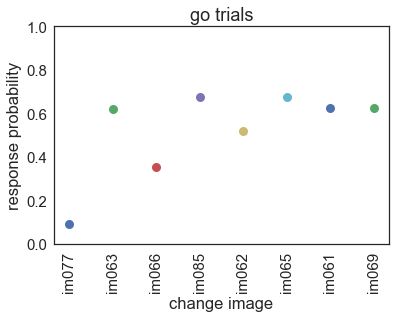

In [108]:
colors = sns.color_palette()
trial_type = 'go'
for i,image in enumerate(images): 
    selected_trials = trials[(trials.change_image_name==image)&(trials.trial_type==trial_type)]
    response_probability = selected_trials.response.mean()
    plt.plot(i,response_probability,'o')
plt.xticks(np.arange(0,len(images),1),images,rotation=90)
plt.ylabel('response probability')
plt.xlabel('change image')
plt.title('go trials')
plt.ylim(0,1)

(0, 1)

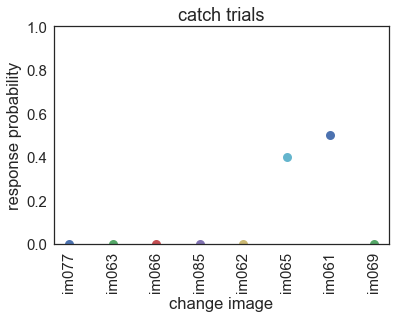

In [109]:
colors = sns.color_palette()
trial_type = 'catch'
for i,image in enumerate(images): 
    selected_trials = trials[(trials.change_image_name==image)&(trials.trial_type==trial_type)]
    response_probability = selected_trials.response.mean()
    plt.plot(i,response_probability,'o')
plt.xticks(np.arange(0,len(images),1),images,rotation=90)
plt.ylabel('response probability')
plt.xlabel('change image')
plt.title('catch trials')
plt.ylim(0,1)

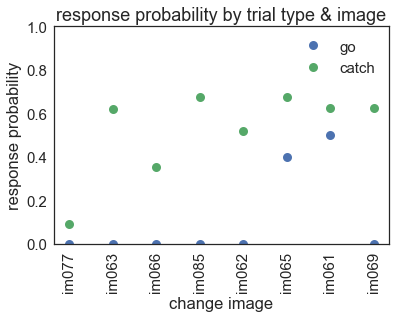

In [110]:
colors = sns.color_palette()
trial_types = trials.trial_type.unique()
for i,image in enumerate(images): 
    for t,trial_type in enumerate(trial_types):
        selected_trials = trials[(trials.change_image_name==image)&(trials.trial_type==trial_type)]
        response_probability = selected_trials.response.mean()
        plt.plot(i,response_probability,'o',color=colors[t])
plt.ylim(0,1)
plt.xticks(np.arange(0,len(images),1),images,rotation=90)
plt.ylabel('response probability')
plt.xlabel('change image')
plt.title('response probability by trial type & image')
plt.legend(['go','catch'])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The ResponseAnalysis object </h2>
<p>The ResponseAnalysis class takes a VisualBehaviorDataset object and extracts cell responses for the stimulus flashes in 'stimulus_table' and for the trials in 'trials'. 
<p>This does the work of temporal alignment for you, and translates between 'timestamps_stimulus' and 'timestamps_ophys' to get the times in the dF/F trace that correspond to stimulus presentations, in 'dataset.stimulus_table' and behavioral trial change times in 'dataset.trials'
<p>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.1:** Generate the ResponseAnalysis object by passing in your dataset. 

<p> What is available to you in the ResponseAnalysis class? Use help to check the documentation, or look directly at the code to see what operations are performed. 
</div>

In [111]:
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis 

In [112]:
analysis = ResponseAnalysis(dataset)

loading trial response dataframe
loading flash response dataframe


In [113]:
help(ResponseAnalysis)

Help on class ResponseAnalysis in module visual_behavior.ophys.response_analysis.response_analysis:

class ResponseAnalysis(__builtin__.object)
 |  Contains methods for organizing responses by trial or by  visual stimulus flashes in a DataFrame.
 |  
 |  For trial responses, a segment of the dF/F trace for each cell is extracted for each trial in the trials records in a +/-4 seconds window (the 'trial_window') around the change time.
 |  The mean_response for each cell is taken in a 500ms window after the change time (the 'response_window').
 |  The trial_response_df also contains behavioral metadata such as lick times, running speed, reward rate, and initial and change stimulus names.
 |  
 |  For stimulus flashes, the mean response is taken in a 500ms window after each stimulus presentation (the 'response_window') in the stimulus_table.
 |  The flash_response_df also contains metadata such as the time from last lick, time since last stimulus change, and mean running speed during each

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.2:** Explore the 'trial_response_df' of the ResponseAnalysis object

<p>What is in 'trial_response_df' ? What are the columns? Whats different than the trials records in the dataset object? 
</div>

In [114]:
rdf = analysis.trial_response_df
rdf.keys()

Index([u'trial', u'cell', u'cell_specimen_id', u'trace', u'timestamps',
       u'mean_response', u'baseline_response', u'p_value', u'sd_over_baseline',
       u'running_speed_trace', u'running_speed_timestamps',
       u'mean_running_speed', u'trial_type', u'initial_image_name',
       u'change_image_name', u'change_time', u'lick_times', u'reward_times',
       u'behavioral_response', u'behavioral_response_type',
       u'behavioral_response_time', u'behavioral_response_latency',
       u'rewarded', u'reward_rate', u'reward_volume', u'cumulative_volume',
       u'cumulative_reward_number', u'reward_lick_count', u'color',
       u'initial_image_category', u'change_image_category', u'change_frame',
       u'lick_frames', u'reward_frames', u'startframe', u'starttime',
       u'endframe', u'endtime', u'trial_length', u'stim_duration', u'stimulus',
       u'task', u'mouse_id', u'behavior_session_uuid', u'startdatetime'],
      dtype='object')

In [115]:
rdf.head()

,trial,cell,cell_specimen_id,trace,timestamps,mean_response,baseline_response,p_value,sd_over_baseline,running_speed_trace,...,starttime,endframe,endtime,trial_length,stim_duration,stimulus,task,mouse_id,behavior_session_uuid,startdatetime
0,0,0,719333911,"[-0.0341845226221, -0.0222363582266, 0.0619931...","[142.75465, 142.78694, 142.81923, 142.85152, 1...",0.017919,0.006720,0.620637,0.260571,"[26.0515611699, 24.1558756149, 21.0925016656, ...",...,143.73711,6793,148.2408,4.503835,0.25,Natural_Images_Lum_Matched_set_training_2017.0...,DoC_NaturalImages_Ophys_SessionA,M385255,None,2018-07-12 10:55:19.576000-07:00
1,0,1,719333915,"[0.0484321614459, 0.017575266082, -0.035155615...","[142.75465, 142.78694, 142.81923, 142.85152, 1...",0.002927,0.021561,0.195686,0.081255,"[26.0515611699, 24.1558756149, 21.0925016656, ...",...,143.73711,6793,148.2408,4.503835,0.25,Natural_Images_Lum_Matched_set_training_2017.0...,DoC_NaturalImages_Ophys_SessionA,M385255,None,2018-07-12 10:55:19.576000-07:00
2,0,2,719333917,"[-0.00436815349183, -0.0099722054295, -0.02006...","[142.75465, 142.78694, 142.81923, 142.85152, 1...",-0.010491,-0.016642,0.745467,-0.196375,"[26.0515611699, 24.1558756149, 21.0925016656, ...",...,143.73711,6793,148.2408,4.503835,0.25,Natural_Images_Lum_Matched_set_training_2017.0...,DoC_NaturalImages_Ophys_SessionA,M385255,None,2018-07-12 10:55:19.576000-07:00
3,0,3,719333919,"[-0.0215444126666, -0.0529458895098, -0.085730...","[142.75465, 142.78694, 142.81923, 142.85152, 1...",0.007670,-0.020480,0.119278,0.169735,"[26.0515611699, 24.1558756149, 21.0925016656, ...",...,143.73711,6793,148.2408,4.503835,0.25,Natural_Images_Lum_Matched_set_training_2017.0...,DoC_NaturalImages_Ophys_SessionA,M385255,None,2018-07-12 10:55:19.576000-07:00
4,0,4,719333921,"[0.0404718712765, 0.0429019691893, 0.047975893...","[142.75465, 142.78694, 142.81923, 142.85152, 1...",0.027847,0.015650,0.466264,0.608709,"[26.0515611699, 24.1558756149, 21.0925016656, ...",...,143.73711,6793,148.2408,4.503835,0.25,Natural_Images_Lum_Matched_set_training_2017.0...,DoC_NaturalImages_Ophys_SessionA,M385255,None,2018-07-12 10:55:19.576000-07:00


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.3:** Plot a cell's response for a single trial 

<p>Each row of 'trial_response_df' corresponds to a single trial for a single cell from the experiment. Find the row of 'trial_response_df' that has the largest value of the 'mean_response' column. 

<p>What cell had the largest response? Assign the cell index to the variable 'cell'

<p>What image evoked the largest response? Assign the image name to a variable called 'change_image_name'

<p>Was it a go or catch trial? Assign the trial type to a variable called 'trial_type'

<p>Plot the dF/F trace for that trial

<p>Bonus: Plot time in seconds relative to the trial change time, using the 'timestamps' column and knowledge of the range of the 'trial_window'

</div>

In [116]:
largest_response = rdf[rdf.mean_response==rdf.mean_response.max()]
largest_response

,trial,cell,cell_specimen_id,trace,timestamps,mean_response,baseline_response,p_value,sd_over_baseline,running_speed_trace,...,starttime,endframe,endtime,trial_length,stim_duration,stimulus,task,mouse_id,behavior_session_uuid,startdatetime
6882,116,38,719334081,"[0.0487414343038, 0.0948941468471, 0.009388199...","[1661.43507, 1661.46737, 1661.49966, 1661.5319...",2.46125,0.019795,4.784913e-09,54.045326,"[31.1894082437, 31.9595712281, 31.9500110847, ...",...,1660.91071,97955,1669.1675,8.256975,0.25,Natural_Images_Lum_Matched_set_training_2017.0...,DoC_NaturalImages_Ophys_SessionA,M385255,None,2018-07-12 10:55:19.576000-07:00


In [117]:
cell = largest_response.cell.values[0]
print 'cell with largest response:',cell

cell with largest response: 38


In [118]:
trial = largest_response.trial.values[0]
print 'trial that evoked largest response for this cell:',trial

trial that evoked largest response for this cell: 116


In [119]:
image_name = largest_response.change_image_name.values[0]
print 'image_name:', image_name
trial_type = largest_response.trial_type.values[0]
print 'trial_type:',trial_type

image_name: im069
trial_type: go


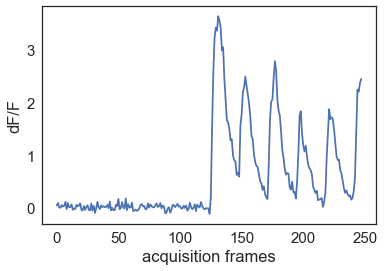

In [120]:
plt.plot(largest_response.trace.values[0])
plt.xlabel('acquisition frames')
plt.ylabel('dF/F')

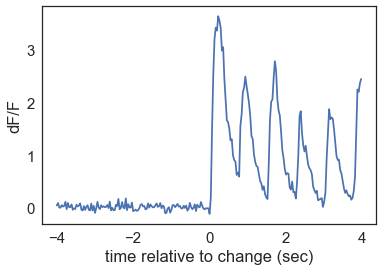

In [121]:
times = largest_response.timestamps.values[0]
times = times-times[0]
times = times-4
plt.plot(times,largest_response.trace.values[0])
plt.xlabel('time relative to change (sec)')
plt.ylabel('dF/F')

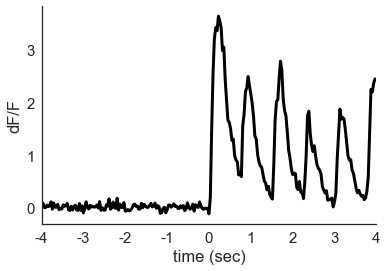

In [122]:
#Alternatively, use the plotting functions in visual_behavior.ophys.plotting.summary_figures
import visual_behavior.ophys.plotting.summary_figures as sf

trace = largest_response.trace.values[0]
frame_rate = analysis.ophys_frame_rate
sf.plot_single_trial_trace(trace, frame_rate, label=None, color='k', interval_sec=1, xlims=[-4, 4], ax=None)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.4:** Plot a cell's trial averaged response for a set of conditions

<p>Get the dF/F traces for all trials that meet the conditions that evoked the max response (combination of trial_type and image_name) for the cell identified above and assign to a variable called 'traces'

<p>Hint 1: Use 'cell', 'image_name', and 'trial_type' to index into 'trial_response_df'

<p>Hint 2: Make sure to extract the an array of the values of response, not as a series
</div>

In [123]:
traces = rdf[(rdf.cell==cell)&(rdf.trial_type==trial_type)&(rdf.change_image_name==image_name)].trace
traces

1041     [0.0558028141711, 0.0560015195238, 0.011555945...
1218     [0.00702525468931, 0.0360659183041, -0.0127236...
1808     [0.0553604878225, 0.025183302903, -0.022527919...
2162     [0.00258997124095, -0.0225471901432, -0.051958...
2516     [-0.00948851488254, -0.0160058666585, -0.03111...
3755     [0.029905197452, 0.0325416982156, 0.0516707541...
5466     [-0.112178762135, 0.00333763998505, -0.0180339...
5643     [0.0293000102694, 0.0457363409215, 0.065675355...
5997     [-0.0470720363299, 0.00128024915747, -0.074980...
6233     [0.0132551563739, 0.0370672508474, 0.051774992...
6882     [0.0487414343038, 0.0948941468471, 0.009388199...
7000     [-0.0725788852621, -0.0103691783377, -0.059950...
7236     [0.0277719796496, 0.0820311068482, -0.04606674...
7649     [0.0119041003733, 0.0130914397131, 0.014408028...
8298     [-0.0272576588543, -0.0681492692762, -0.040506...
9183     [-0.0237112778442, 0.020751903157, 0.043764099...
9714     [-0.0140450471162, -0.00295824556004, 0.036793.

In [124]:
traces = traces.values

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.4 (continued):** Plot a cell's trial averaged trace for a set of conditions

<p>Use the povided plotting function to plot the trial averaged trace for your cell. Note the dynamics of the cell's response. What could be causing the changes in response strength? 

<p>Bonus: Use the function 'plot_mean_trace' in visual_behavior.ophys.plotting.summary_figures

<p>Extra Bonus: Use the function 'plot_flashes_on_trace' to display stimulus presentation times

</div>

In [125]:
def plot_mean_trace(traces):
    fig,ax = plt.subplots()
    if len(traces) > 0:
        trace = np.mean(traces,axis=0)
        times = np.arange(0, len(trace), 1)
        sem = (traces.std()) / np.sqrt(float(len(traces)))
        ax.plot(trace,linewidth=3)
        ax.fill_between(times, trace + sem, trace - sem, alpha=0.5)
        ax.set_ylabel('dF/F')
        ax.set_xlabel('ophys frames')
    sns.despine(ax=ax)
    return ax

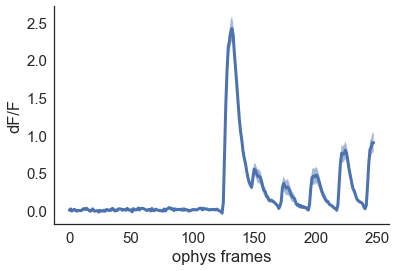

In [126]:
plot_mean_trace(traces)

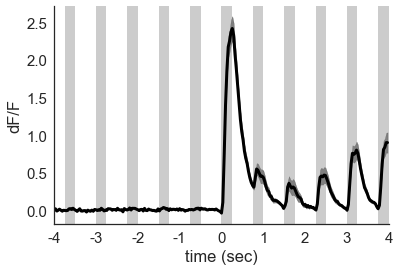

In [127]:
fig,ax = plt.subplots()
sf.plot_mean_trace(traces, analysis.ophys_frame_rate, label=None, color='k', interval_sec=1, xlims=[-4, 4], ax=ax)
sf.plot_flashes_on_trace(ax, analysis, trial_type=None, omitted=False, alpha=0.4)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.5:** Plot an image tuning curve from stimulus flashes

<p>Get the 'flash_response_df' from the analysis object. What are the columns? What are the rows? 

<p>Filter the dataframe to get the stimulus flashes for the 'image_name' and 'cell' identified above.

<p>Get the mean and standard error for the 'mean_response' column for the filtered dataframe

<p>Hint: Use 'from scipy.stats import sem' to get a function to compute standard error of the mean
</div>

In [128]:
fdf = analysis.flash_response_df
fdf.head()

,cell,flash_number,start_time,image_name,mean_response
0,0,0,34.88175,im061,-0.007589
1,0,1,35.63224,im061,-0.051502
2,0,2,36.38278,im061,-0.078567
3,0,3,37.13337,im061,-0.012613
4,0,4,37.88405,im061,-0.034343


In [129]:
filtered = fdf[(fdf.cell==cell)&(fdf.image_name==image_name)]
filtered

,cell,flash_number,start_time,image_name,mean_response
174105,38,27,55.89871,im069,2.891007
174106,38,28,56.64932,im069,2.076797
174107,38,29,57.40004,im069,1.106579
174108,38,30,58.15057,im069,1.763680
174109,38,31,58.90120,im069,0.697463
174110,38,32,59.65180,im069,1.214717
174111,38,33,60.40250,im069,0.620415
174112,38,34,61.15307,im069,1.544159
174113,38,35,61.90360,im069,1.120792
174114,38,36,62.65428,im069,1.104937


In [130]:
mean = filtered.mean_response.mean()
print 'mean response =',mean

mean response = 0.434964862863


In [131]:
from scipy.stats import sem
std_err = sem(filtered.mean_response.values)
print 'standard error of the mean =',std_err

standard error of the mean = 0.0218523629577


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.5 (continued):** Plot an image tuning curve from stimulus flashes

<p>Loop through all images and plot the mean and standard error for each image to make a tuning curve. Which image drove the strongest response on average? Is it the same image that gave the strongest single trial response?

<p>Hint: Use plt.errorbar() in addition to plt.plot()
</div>

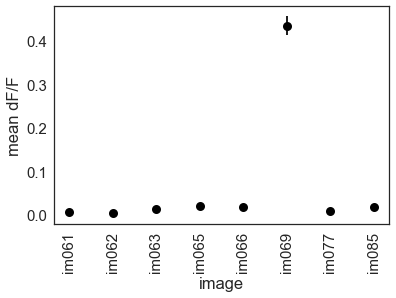

In [132]:
images = np.sort(fdf.image_name.unique())
for i,image_name in enumerate(images): 
    responses = fdf[(fdf.cell==cell)&(fdf.image_name==image_name)].mean_response.values
    mean_response = np.mean(responses)
    std_err = sem(responses)

    plt.plot(i,mean_response,'o',color='k')
    plt.errorbar(i,mean_response,yerr=std_err,color='k')
plt.ylabel('mean dF/F')
plt.xlabel('image')
plt.xticks(np.arange(0,len(images),1),images,rotation=90);


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Computing image selectivity </h3>
<p>'lifetime sparseness' is a metric for how selective and sparse a cell's activity is across conditions. A high value of this metric indicates high selectivity, a differential response to one or a few stimulus conditions over others. A low value of this metric indicates a similar response across all conditions. 

<p>We will compute this metric for single cells and take the mean across the population. Before taking the mean, we will filter out cells that do not have a signficant image response.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 6.1:** Compute lifetime sparseness for a single cell using responses after a stimulus change instead of all stimulus flashes 

<p>First, filter 'trial_response_df' to select only 'go' trials and assign to a variable called 'df'.

<p>Loop through each 'change_image_name' in 'df.change_image_name.unique()' and take the average of the 'mean_response' values for all trials of that image, and save the average value to a list (length should equal the number of images). Then, convert the list to an array. 

<p>Use the function below to compute the lifetime sparsness metric for your cell using your array of image responses. 
</div>

In [133]:
def compute_lifetime_sparseness(image_responses):
    # image responses should be an array of the trial averaged responses to each image
    # sparseness = 1-(sum of trial averaged responses to images / N)squared / (sum of (squared mean responses / n)) / (1-(1/N))
    # N = number of images
    # after Vinje & Gallant, 2000; Froudarakis et al., 2014
    N = float(len(image_responses))
    ls = ((1-(1/N) * ((np.power(image_responses.sum(axis=0),2)) / (np.power(image_responses,2).sum(axis=0)))) / (1-(1/N)))
    return ls

In [134]:
df = analysis.trial_response_df[analysis.trial_response_df.trial_type=='go']

In [135]:
images = df.change_image_name.unique()
image_responses = []
for i,change_image_name in enumerate(images): 
    responses = df[(df.cell==cell)&(df.change_image_name==change_image_name)].mean_response.values
    mean_response = np.mean(responses)
    image_responses.append(mean_response)
image_responses = np.asarray(image_responses)

In [136]:
ls = compute_lifetime_sparseness(image_responses)
print ls

0.881433603565


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 6.1 (continued):** Compute lifetime sparseness for a single cell using responses after a stimulus change

<p>Plot the tuning curve for this cell again, now with the trial responses in 'df', instead of the stimulus flash response. Include the value of lifetime sparseness in the figure title.

<p>How does the tuning curve compare with the one generated above using all stimulus presentations? 

<p> How selective is this cell? Try another cell for comparison. 
</div>

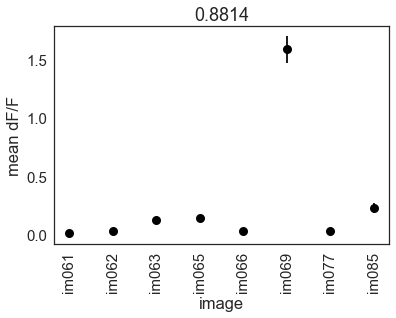

In [137]:
images = np.sort(df.change_image_name.unique())
image_responses = []
for i,change_image_name in enumerate(images): 
    responses = df[(df.cell==cell)&(df.change_image_name==change_image_name)].mean_response.values
    mean_response = np.mean(responses)
    std_err = sem(responses)
    
    image_responses.append(mean_response)
    
    plt.plot(i,mean_response,'o',color='k')
    plt.errorbar(i,mean_response,yerr=std_err,color='k')
plt.ylabel('mean dF/F')
plt.xlabel('image')
plt.xticks(np.arange(0,len(images),1),images,rotation=90);

ls = compute_lifetime_sparseness(np.asarray(image_responses))
plt.title(np.round(ls,4))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 6.2:** Identify cells with a significant image response
<p>The 'p_value' column of the 'trial_response_df' is computed as a one-way ANOVA comparing the dF/F trace in the 500ms before the change time with a 500ms window after the change time.  
<p>Let's define responsive cells as having at least 10% of trials with a p_value < 0.005
<p>Loop through all cells, evaluate the fraction of trials with p_value < 0.005 and make a list of the indicies of responsive cells. Assign the list to 'responsive_cells'
<p>What fraction of cells in this experiment were responsive following a stimulus change? 
</div>

In [138]:
responsive_cells = []
for cell in df.cell.unique():
    cell_data = df[(df.cell==cell)]
    total_trials = len(cell_data)
    responsive_trials = len(cell_data[cell_data.p_value<0.005])
    fraction_responsive_trials = responsive_trials/float(total_trials)
    if fraction_responsive_trials > 0.1: 
        responsive_cells.append(cell)

In [139]:
print 'fraction responsive cells = ',len(responsive_cells)/float(len(df.cell.unique()))

fraction responsive cells =  0.305084745763


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 6.3:** Compute lifetime sparseness for responsive cells and take the mean  
<p>Loop through each cell in 'responsive_cells', compute lifetime sparseness as you did above, and add the value to a list. 
<p>Convert the list to an array and take the mean.
<p>Add your mean value to the plot on the whiteboard in the appropriate column based on your experiment's metadata
</div>

In [140]:
images = np.sort(df.change_image_name.unique())
lifetime_sparseness_values = []
for cell in responsive_cells: 
    image_responses = []
    for i,change_image_name in enumerate(images): 
        responses = df[(df.cell==cell)&(df.change_image_name==change_image_name)].mean_response.values
        mean_response = np.mean(responses)
        std_err = sem(responses)

        image_responses.append(mean_response)
    ls = compute_lifetime_sparseness(np.asarray(image_responses))
    lifetime_sparseness_values.append(ls)
lifetime_sparseness_values = np.asarray(lifetime_sparseness_values)
mean_lifetime_sparseness = np.mean(lifetime_sparseness_values)

In [141]:
mean_lifetime_sparseness

0.64402696098277235

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Bonus exercise 6.4:** Compute lifetime sparseness for catch trials, or for all stimulus flashes 
    
<p>Repeat the exercise above using 'trial_response_df', filtered to include only 'catch' trials where no change in stimulus identity occured, or using 'flash_response_df' to include all stimulus presentations.

<p>How does the result compare to selectivity on 'go' trials only? Why would it be different? 
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Project ideas </h3>
<p>Below is a list of suggested project ideas for working with the Visual Behavior dataset

</div>

Projects: 
* other metrics across cre_lines, areas or stimulus types: time to peak, reliability, 
* characterize behavioral or neural states within a session 
* compare metrics between states
* flash-wise analysis - adaptation, facilitation, expectation 
* functional clustering on response profiles 
* motor signals - modulation by running & licking 
* omitted flashes 

Figures you could make and add to visual_behavior.ophys.plotting.summary_figures: 
* make a heatmap of the mean response to each image across all cells for session_type = 'behavior_session_A', where rows are cells and columns are different images. Sort the cells first by the image that drove the max response for each cell, then by the max response. 
* make a heatmap of single trial responses for a given cell, separately for each image that was shown. Order by trial type (hit, miss, correct reject, false alarm). 